# Details of pre-trained models:

## ShuffleNet

**Pros:**
- ShuffleNet employs pointwise group convolutions to reduce computational cost, making it suitable for
resource-constrained environments.
- It's known for its computational efficiency while providing reasonable accuracy.

Why it's a good fit for Fashion MNIST: Fashion MNIST doesn't require the complexity of larger models, and
ShuffleNet's efficiency can handle the task effectively.

# Import libraries

In [1]:
import pickle

import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models

# Prepare ShuffleNet model for training

In [2]:
BATCH_SIZE = 16
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 35
NAME_OF_MODEL = "shufflenet_v2_x0_5"
EARLY_STOPPING_PATIENCE = 15

desired_size = 224
transform = transforms.Compose([transforms.Resize(desired_size),
                                transforms.Pad(padding=(desired_size - 224) // 2),
                                torchvision.transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])

trainset = datasets.FashionMNIST('data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [3]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [4]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


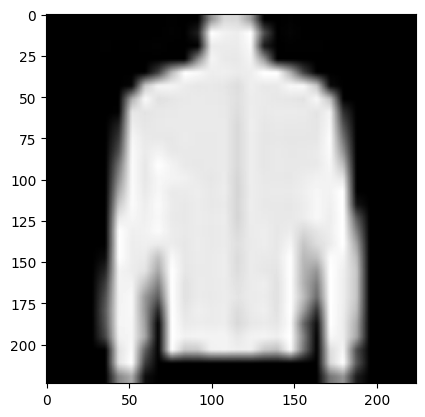

Label: 4


In [6]:
#nex iter gets next 100 images
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[7][0].squeeze()
label = train_labels[7]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
all_models = models.list_models()
m1 = models.shufflenet_v2_x0_5(num_classes=10)
# Move your model to the GPU if available
m1.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

Freeze only FC layer

In [10]:
# Freeze all layers
for param in m1.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in m1.fc.parameters():
    param.requires_grad = True

## Find out optimal batch size

In [11]:
batch_sizes = [8, 16, 32, 64, 128]

from training_and_evaluate import train_and_eval

batch_tr_info, batch_te_info = train_and_eval(model=m1, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="unfreeze_FC_layer",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE,
                                              NUM_OF_WORKERS=NUM_OF_WORKERS)

Device: cuda:0
Epoch 1 Training...


100%|██████████| 7500/7500 [02:19<00:00, 53.75it/s]


Epoch 1 Testing...


100%|██████████| 1250/1250 [00:20<00:00, 61.70it/s]


Epoch 1: Train_accuracy: 30.17%, Train_loss: 1.891353, Test_accuracy: 37.99%, Test_loss: 1.627149
Epoch 2 Training...


100%|██████████| 7500/7500 [02:05<00:00, 59.71it/s]


Epoch 2 Testing...


100%|██████████| 1250/1250 [00:19<00:00, 62.68it/s]


Epoch 2: Train_accuracy: 39.18%, Train_loss: 1.622431, Test_accuracy: 44.47%, Test_loss: 1.465737
Epoch 3 Training...


100%|██████████| 7500/7500 [02:10<00:00, 57.37it/s]


Epoch 3 Testing...


100%|██████████| 1250/1250 [00:21<00:00, 57.43it/s]


Epoch 3: Train_accuracy: 41.70%, Train_loss: 1.547665, Test_accuracy: 49.63%, Test_loss: 1.376549
Epoch 4 Training...


100%|██████████| 7500/7500 [02:17<00:00, 54.45it/s]


Epoch 4 Testing...


100%|██████████| 1250/1250 [00:21<00:00, 57.44it/s]


Epoch 4: Train_accuracy: 43.42%, Train_loss: 1.505955, Test_accuracy: 47.22%, Test_loss: 1.404336
Epoch 5 Training...


100%|██████████| 7500/7500 [02:16<00:00, 54.94it/s]


Epoch 5 Testing...


100%|██████████| 1250/1250 [00:21<00:00, 58.09it/s]


Epoch 5: Train_accuracy: 44.55%, Train_loss: 1.469706, Test_accuracy: 48.97%, Test_loss: 1.357784
Epoch 6 Training...


100%|██████████| 7500/7500 [02:16<00:00, 54.86it/s]


Epoch 6 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 75.31it/s]


Epoch 6: Train_accuracy: 45.25%, Train_loss: 1.450275, Test_accuracy: 49.23%, Test_loss: 1.339239
Epoch 7 Training...


100%|██████████| 7500/7500 [01:44<00:00, 71.60it/s]


Epoch 7 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 76.62it/s] 


Epoch 7: Train_accuracy: 45.78%, Train_loss: 1.442796, Test_accuracy: 52.89%, Test_loss: 1.284101
Epoch 8 Training...


100%|██████████| 7500/7500 [01:45<00:00, 70.81it/s]


Epoch 8 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 70.86it/s]


Epoch 8: Train_accuracy: 46.38%, Train_loss: 1.423000, Test_accuracy: 51.18%, Test_loss: 1.288008
Epoch 9 Training...


100%|██████████| 7500/7500 [01:45<00:00, 70.79it/s]


Epoch 9 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 76.43it/s]


Epoch 9: Train_accuracy: 46.52%, Train_loss: 1.414090, Test_accuracy: 50.49%, Test_loss: 1.362968
Epoch 10 Training...


100%|██████████| 7500/7500 [01:45<00:00, 70.87it/s]


Epoch 10 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 75.06it/s] 


Epoch 10: Train_accuracy: 47.22%, Train_loss: 1.399351, Test_accuracy: 50.17%, Test_loss: 1.307089
Epoch 11 Training...


100%|██████████| 7500/7500 [01:53<00:00, 66.10it/s]


Epoch 11 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 66.89it/s]


Epoch 11: Train_accuracy: 47.31%, Train_loss: 1.397841, Test_accuracy: 52.91%, Test_loss: 1.243884
Epoch 12 Training...


100%|██████████| 7500/7500 [02:01<00:00, 61.68it/s]


Epoch 12 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 66.36it/s]


Epoch 12: Train_accuracy: 47.64%, Train_loss: 1.386709, Test_accuracy: 53.79%, Test_loss: 1.244543
Epoch 13 Training...


100%|██████████| 7500/7500 [01:57<00:00, 63.65it/s]


Epoch 13 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 68.57it/s]


Epoch 13: Train_accuracy: 47.91%, Train_loss: 1.379849, Test_accuracy: 51.52%, Test_loss: 1.303511
Epoch 14 Training...


100%|██████████| 7500/7500 [01:59<00:00, 62.53it/s]


Epoch 14 Testing...


100%|██████████| 1250/1250 [00:20<00:00, 62.35it/s]


Epoch 14: Train_accuracy: 48.07%, Train_loss: 1.374129, Test_accuracy: 52.23%, Test_loss: 1.260414
Epoch 15 Training...


100%|██████████| 7500/7500 [01:50<00:00, 68.11it/s]


Epoch 15 Testing...


100%|██████████| 1250/1250 [00:23<00:00, 54.28it/s]


Epoch 15: Train_accuracy: 48.42%, Train_loss: 1.364129, Test_accuracy: 49.75%, Test_loss: 1.328499
Epoch 16 Training...


100%|██████████| 7500/7500 [01:56<00:00, 64.16it/s]


Epoch 16 Testing...


100%|██████████| 1250/1250 [00:20<00:00, 60.94it/s]


Epoch 16: Train_accuracy: 48.58%, Train_loss: 1.360993, Test_accuracy: 53.25%, Test_loss: 1.222649
Epoch 17 Training...


100%|██████████| 7500/7500 [01:55<00:00, 64.80it/s]


Epoch 17 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 69.66it/s]


Epoch 17: Train_accuracy: 48.95%, Train_loss: 1.351473, Test_accuracy: 55.42%, Test_loss: 1.211462
Epoch 18 Training...


100%|██████████| 7500/7500 [01:52<00:00, 66.72it/s]


Epoch 18 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 69.44it/s]


Epoch 18: Train_accuracy: 48.98%, Train_loss: 1.351004, Test_accuracy: 54.55%, Test_loss: 1.214855
Epoch 19 Training...


100%|██████████| 7500/7500 [01:54<00:00, 65.73it/s]


Epoch 19 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 70.96it/s]


Epoch 19: Train_accuracy: 49.17%, Train_loss: 1.346014, Test_accuracy: 53.86%, Test_loss: 1.212215
Epoch 20 Training...


100%|██████████| 7500/7500 [01:54<00:00, 65.29it/s]


Epoch 20 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 72.74it/s]


Epoch 20: Train_accuracy: 49.09%, Train_loss: 1.347918, Test_accuracy: 51.84%, Test_loss: 1.290657
Epoch 21 Training...


100%|██████████| 7500/7500 [01:48<00:00, 68.87it/s]


Epoch 21 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 74.83it/s] 


Epoch 21: Train_accuracy: 49.34%, Train_loss: 1.337158, Test_accuracy: 55.16%, Test_loss: 1.189575
Epoch 22 Training...


100%|██████████| 7500/7500 [01:43<00:00, 72.18it/s]


Epoch 22 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 75.56it/s] 


Epoch 22: Train_accuracy: 49.33%, Train_loss: 1.344727, Test_accuracy: 49.67%, Test_loss: 1.369398
Epoch 23 Training...


100%|██████████| 7500/7500 [01:43<00:00, 72.12it/s]


Epoch 23 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 74.77it/s]


Epoch 23: Train_accuracy: 49.72%, Train_loss: 1.336375, Test_accuracy: 55.30%, Test_loss: 1.207795
Epoch 24 Training...


100%|██████████| 7500/7500 [01:45<00:00, 71.34it/s]


Epoch 24 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 72.12it/s] 


Epoch 24: Train_accuracy: 49.82%, Train_loss: 1.330649, Test_accuracy: 55.47%, Test_loss: 1.203623
Epoch 25 Training...


100%|██████████| 7500/7500 [01:50<00:00, 67.87it/s]


Epoch 25 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 68.72it/s] 


Epoch 25: Train_accuracy: 49.97%, Train_loss: 1.323322, Test_accuracy: 55.65%, Test_loss: 1.165060
Epoch 26 Training...


100%|██████████| 7500/7500 [01:51<00:00, 67.48it/s]


Epoch 26 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 67.97it/s]


Epoch 26: Train_accuracy: 50.31%, Train_loss: 1.319569, Test_accuracy: 52.98%, Test_loss: 1.278149
Epoch 27 Training...


100%|██████████| 7500/7500 [01:52<00:00, 66.56it/s]


Epoch 27 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 74.22it/s]


Epoch 27: Train_accuracy: 49.74%, Train_loss: 1.329122, Test_accuracy: 55.34%, Test_loss: 1.212849
Epoch 28 Training...


100%|██████████| 7500/7500 [01:52<00:00, 66.62it/s]


Epoch 28 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 71.97it/s] 


Epoch 28: Train_accuracy: 50.00%, Train_loss: 1.322981, Test_accuracy: 53.26%, Test_loss: 1.222804
Epoch 29 Training...


100%|██████████| 7500/7500 [01:49<00:00, 68.38it/s]


Epoch 29 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 73.85it/s]


Epoch 29: Train_accuracy: 50.15%, Train_loss: 1.320379, Test_accuracy: 46.10%, Test_loss: 1.447864
Epoch 30 Training...


100%|██████████| 7500/7500 [02:05<00:00, 59.57it/s]


Epoch 30 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 66.45it/s]


Epoch 30: Train_accuracy: 50.05%, Train_loss: 1.318682, Test_accuracy: 52.89%, Test_loss: 1.252573
Epoch 31 Training...


100%|██████████| 7500/7500 [01:49<00:00, 68.52it/s]


Epoch 31 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 71.40it/s]


Epoch 31: Train_accuracy: 50.36%, Train_loss: 1.313708, Test_accuracy: 51.00%, Test_loss: 1.261873
Epoch 32 Training...


100%|██████████| 7500/7500 [01:49<00:00, 68.66it/s]


Epoch 32 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 73.07it/s]


Epoch 32: Train_accuracy: 50.69%, Train_loss: 1.311454, Test_accuracy: 54.70%, Test_loss: 1.211398
Epoch 33 Training...


100%|██████████| 7500/7500 [01:52<00:00, 66.44it/s]


Epoch 33 Testing...


100%|██████████| 1250/1250 [00:17<00:00, 71.22it/s]


Epoch 33: Train_accuracy: 50.48%, Train_loss: 1.316645, Test_accuracy: 56.69%, Test_loss: 1.172596
Epoch 34 Training...


100%|██████████| 7500/7500 [02:03<00:00, 60.96it/s]


Epoch 34 Testing...


100%|██████████| 1250/1250 [00:16<00:00, 74.99it/s]


Epoch 34: Train_accuracy: 50.27%, Train_loss: 1.308102, Test_accuracy: 55.22%, Test_loss: 1.196938
Epoch 35 Training...


100%|██████████| 7500/7500 [01:50<00:00, 67.88it/s]


Epoch 35 Testing...


100%|██████████| 1250/1250 [00:18<00:00, 69.00it/s]


Epoch 35: Train_accuracy: 50.46%, Train_loss: 1.310419, Test_accuracy: 54.12%, Test_loss: 1.267575
Epoch 1 Training...


100%|██████████| 3750/3750 [01:07<00:00, 55.64it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:11<00:00, 52.42it/s]


Epoch 1: Train_accuracy: 31.59%, Train_loss: 1.880363, Test_accuracy: 38.15%, Test_loss: 1.691938
Epoch 2 Training...


100%|██████████| 3750/3750 [01:04<00:00, 57.99it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.70it/s]


Epoch 2: Train_accuracy: 41.49%, Train_loss: 1.586933, Test_accuracy: 46.17%, Test_loss: 1.448781
Epoch 3 Training...


100%|██████████| 3750/3750 [01:05<00:00, 57.20it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.88it/s]


Epoch 3: Train_accuracy: 43.90%, Train_loss: 1.502753, Test_accuracy: 47.22%, Test_loss: 1.413480
Epoch 4 Training...


100%|██████████| 3750/3750 [01:08<00:00, 55.14it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.49it/s]


Epoch 4: Train_accuracy: 45.56%, Train_loss: 1.450574, Test_accuracy: 46.76%, Test_loss: 1.388178
Epoch 5 Training...


100%|██████████| 3750/3750 [01:15<00:00, 49.61it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:14<00:00, 43.84it/s]


Epoch 5: Train_accuracy: 46.74%, Train_loss: 1.416352, Test_accuracy: 47.27%, Test_loss: 1.413137
Epoch 6 Training...


100%|██████████| 3750/3750 [01:06<00:00, 56.43it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:11<00:00, 52.77it/s]


Epoch 6: Train_accuracy: 47.82%, Train_loss: 1.384573, Test_accuracy: 48.27%, Test_loss: 1.338528
Epoch 7 Training...


100%|██████████| 3750/3750 [01:07<00:00, 55.61it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.08it/s]


Epoch 7: Train_accuracy: 48.21%, Train_loss: 1.372662, Test_accuracy: 52.60%, Test_loss: 1.268442
Epoch 8 Training...


100%|██████████| 3750/3750 [01:10<00:00, 53.14it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.12it/s]


Epoch 8: Train_accuracy: 48.76%, Train_loss: 1.357602, Test_accuracy: 49.51%, Test_loss: 1.365812
Epoch 9 Training...


100%|██████████| 3750/3750 [01:09<00:00, 53.63it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:14<00:00, 44.50it/s]


Epoch 9: Train_accuracy: 49.09%, Train_loss: 1.343850, Test_accuracy: 51.97%, Test_loss: 1.275945
Epoch 10 Training...


100%|██████████| 3750/3750 [01:11<00:00, 52.24it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.24it/s]


Epoch 10: Train_accuracy: 49.23%, Train_loss: 1.337418, Test_accuracy: 49.21%, Test_loss: 1.295901
Epoch 11 Training...


100%|██████████| 3750/3750 [01:16<00:00, 48.80it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:14<00:00, 44.50it/s]


Epoch 11: Train_accuracy: 49.95%, Train_loss: 1.323207, Test_accuracy: 51.15%, Test_loss: 1.296173
Epoch 12 Training...


100%|██████████| 3750/3750 [01:12<00:00, 51.44it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.97it/s]


Epoch 12: Train_accuracy: 50.21%, Train_loss: 1.314592, Test_accuracy: 53.24%, Test_loss: 1.243182
Epoch 13 Training...


100%|██████████| 3750/3750 [01:29<00:00, 41.93it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:13<00:00, 46.83it/s]


Epoch 13: Train_accuracy: 50.29%, Train_loss: 1.308141, Test_accuracy: 50.59%, Test_loss: 1.290087
Epoch 14 Training...


100%|██████████| 3750/3750 [01:27<00:00, 42.74it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.88it/s]


Epoch 14: Train_accuracy: 50.56%, Train_loss: 1.305377, Test_accuracy: 52.03%, Test_loss: 1.272017
Epoch 15 Training...


100%|██████████| 3750/3750 [01:16<00:00, 48.85it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:15<00:00, 40.69it/s]


Epoch 15: Train_accuracy: 50.94%, Train_loss: 1.294413, Test_accuracy: 51.97%, Test_loss: 1.268906
Epoch 16 Training...


100%|██████████| 3750/3750 [01:10<00:00, 53.28it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.07it/s]


Epoch 16: Train_accuracy: 50.89%, Train_loss: 1.295952, Test_accuracy: 53.41%, Test_loss: 1.219347
Epoch 17 Training...


100%|██████████| 3750/3750 [01:27<00:00, 42.95it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.68it/s]


Epoch 17: Train_accuracy: 51.25%, Train_loss: 1.287232, Test_accuracy: 54.17%, Test_loss: 1.211625
Epoch 18 Training...


100%|██████████| 3750/3750 [01:24<00:00, 44.41it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:13<00:00, 44.74it/s]


Epoch 18: Train_accuracy: 51.46%, Train_loss: 1.278678, Test_accuracy: 54.65%, Test_loss: 1.192985
Epoch 19 Training...


100%|██████████| 3750/3750 [01:23<00:00, 45.05it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:13<00:00, 45.68it/s]


Epoch 19: Train_accuracy: 51.43%, Train_loss: 1.281026, Test_accuracy: 54.25%, Test_loss: 1.206497
Epoch 20 Training...


100%|██████████| 3750/3750 [01:33<00:00, 40.06it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:16<00:00, 38.38it/s]


Epoch 20: Train_accuracy: 51.89%, Train_loss: 1.266381, Test_accuracy: 52.60%, Test_loss: 1.255754
Epoch 21 Training...


100%|██████████| 3750/3750 [01:08<00:00, 54.70it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:13<00:00, 47.47it/s]


Epoch 21: Train_accuracy: 51.80%, Train_loss: 1.269796, Test_accuracy: 53.78%, Test_loss: 1.234135
Epoch 22 Training...


100%|██████████| 3750/3750 [01:08<00:00, 54.79it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.78it/s]


Epoch 22: Train_accuracy: 51.96%, Train_loss: 1.263623, Test_accuracy: 55.47%, Test_loss: 1.187594
Epoch 23 Training...


100%|██████████| 3750/3750 [01:12<00:00, 51.72it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:15<00:00, 40.21it/s]


Epoch 23: Train_accuracy: 51.89%, Train_loss: 1.261867, Test_accuracy: 53.13%, Test_loss: 1.230151
Epoch 24 Training...


100%|██████████| 3750/3750 [01:22<00:00, 45.18it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.36it/s]


Epoch 24: Train_accuracy: 52.72%, Train_loss: 1.249996, Test_accuracy: 55.89%, Test_loss: 1.168312
Epoch 25 Training...


100%|██████████| 3750/3750 [01:11<00:00, 52.19it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.90it/s]


Epoch 25: Train_accuracy: 52.36%, Train_loss: 1.253892, Test_accuracy: 55.30%, Test_loss: 1.194692
Epoch 26 Training...


100%|██████████| 3750/3750 [01:09<00:00, 53.97it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:16<00:00, 37.40it/s]


Epoch 26: Train_accuracy: 52.44%, Train_loss: 1.251378, Test_accuracy: 56.16%, Test_loss: 1.160862
Epoch 27 Training...


100%|██████████| 3750/3750 [01:47<00:00, 34.81it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.39it/s]


Epoch 27: Train_accuracy: 52.25%, Train_loss: 1.254547, Test_accuracy: 54.24%, Test_loss: 1.207058
Epoch 28 Training...


100%|██████████| 3750/3750 [01:50<00:00, 33.79it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.27it/s]


Epoch 28: Train_accuracy: 52.79%, Train_loss: 1.243448, Test_accuracy: 55.13%, Test_loss: 1.196458
Epoch 29 Training...


100%|██████████| 3750/3750 [01:42<00:00, 36.51it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:18<00:00, 34.45it/s]


Epoch 29: Train_accuracy: 52.68%, Train_loss: 1.241558, Test_accuracy: 53.40%, Test_loss: 1.238308
Epoch 30 Training...


100%|██████████| 3750/3750 [01:37<00:00, 38.48it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:16<00:00, 37.03it/s]


Epoch 30: Train_accuracy: 52.85%, Train_loss: 1.240831, Test_accuracy: 55.22%, Test_loss: 1.198805
Epoch 31 Training...


100%|██████████| 3750/3750 [01:39<00:00, 37.56it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:15<00:00, 39.14it/s]


Epoch 31: Train_accuracy: 52.89%, Train_loss: 1.238911, Test_accuracy: 54.61%, Test_loss: 1.215960
Epoch 32 Training...


100%|██████████| 3750/3750 [01:36<00:00, 38.70it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:16<00:00, 37.36it/s]


Epoch 32: Train_accuracy: 52.85%, Train_loss: 1.236119, Test_accuracy: 56.00%, Test_loss: 1.163142
Epoch 33 Training...


100%|██████████| 3750/3750 [01:33<00:00, 40.11it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:15<00:00, 39.37it/s]


Epoch 33: Train_accuracy: 53.22%, Train_loss: 1.230933, Test_accuracy: 53.51%, Test_loss: 1.210513
Epoch 34 Training...


100%|██████████| 3750/3750 [01:36<00:00, 38.69it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:18<00:00, 34.20it/s]


Epoch 34: Train_accuracy: 53.06%, Train_loss: 1.231279, Test_accuracy: 53.60%, Test_loss: 1.199536
Epoch 35 Training...


100%|██████████| 3750/3750 [01:38<00:00, 38.13it/s]


Epoch 35 Testing...


100%|██████████| 625/625 [00:15<00:00, 41.07it/s]


Epoch 35: Train_accuracy: 53.10%, Train_loss: 1.231551, Test_accuracy: 56.89%, Test_loss: 1.144465
Epoch 1 Training...


100%|██████████| 1875/1875 [01:07<00:00, 27.84it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.20it/s]


Epoch 1: Train_accuracy: 31.33%, Train_loss: 1.912460, Test_accuracy: 42.28%, Test_loss: 1.660249
Epoch 2 Training...


100%|██████████| 1875/1875 [01:08<00:00, 27.57it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.84it/s]


Epoch 2: Train_accuracy: 41.61%, Train_loss: 1.609318, Test_accuracy: 44.91%, Test_loss: 1.519243
Epoch 3 Training...


100%|██████████| 1875/1875 [01:06<00:00, 28.33it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:12<00:00, 24.94it/s]


Epoch 3: Train_accuracy: 44.91%, Train_loss: 1.503896, Test_accuracy: 45.14%, Test_loss: 1.471172
Epoch 4 Training...


100%|██████████| 1875/1875 [01:12<00:00, 25.93it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:12<00:00, 24.83it/s]


Epoch 4: Train_accuracy: 46.35%, Train_loss: 1.447242, Test_accuracy: 47.03%, Test_loss: 1.441917
Epoch 5 Training...


100%|██████████| 1875/1875 [01:13<00:00, 25.35it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:13<00:00, 23.65it/s]


Epoch 5: Train_accuracy: 47.70%, Train_loss: 1.407006, Test_accuracy: 45.36%, Test_loss: 1.392597
Epoch 6 Training...


100%|██████████| 1875/1875 [01:15<00:00, 24.98it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:12<00:00, 24.70it/s]


Epoch 6: Train_accuracy: 48.55%, Train_loss: 1.381277, Test_accuracy: 50.84%, Test_loss: 1.324428
Epoch 7 Training...


100%|██████████| 1875/1875 [01:13<00:00, 25.37it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:11<00:00, 27.58it/s]


Epoch 7: Train_accuracy: 49.13%, Train_loss: 1.356254, Test_accuracy: 50.70%, Test_loss: 1.319919
Epoch 8 Training...


100%|██████████| 1875/1875 [01:06<00:00, 28.24it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:11<00:00, 26.66it/s]


Epoch 8: Train_accuracy: 49.82%, Train_loss: 1.339302, Test_accuracy: 49.24%, Test_loss: 1.323654
Epoch 9 Training...


100%|██████████| 1875/1875 [01:01<00:00, 30.47it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.39it/s]


Epoch 9: Train_accuracy: 50.21%, Train_loss: 1.325740, Test_accuracy: 49.53%, Test_loss: 1.301801
Epoch 10 Training...


100%|██████████| 1875/1875 [01:03<00:00, 29.65it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.95it/s]


Epoch 10: Train_accuracy: 50.53%, Train_loss: 1.314276, Test_accuracy: 51.78%, Test_loss: 1.268171
Epoch 11 Training...


100%|██████████| 1875/1875 [01:07<00:00, 27.62it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:11<00:00, 26.94it/s]


Epoch 11: Train_accuracy: 50.96%, Train_loss: 1.301230, Test_accuracy: 52.12%, Test_loss: 1.275772
Epoch 12 Training...


100%|██████████| 1875/1875 [01:08<00:00, 27.56it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:12<00:00, 24.59it/s]


Epoch 12: Train_accuracy: 50.89%, Train_loss: 1.293894, Test_accuracy: 53.19%, Test_loss: 1.251554
Epoch 13 Training...


100%|██████████| 1875/1875 [01:08<00:00, 27.31it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.76it/s]


Epoch 13: Train_accuracy: 51.38%, Train_loss: 1.281412, Test_accuracy: 54.66%, Test_loss: 1.222467
Epoch 14 Training...


100%|██████████| 1875/1875 [01:08<00:00, 27.55it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:12<00:00, 25.49it/s]


Epoch 14: Train_accuracy: 51.74%, Train_loss: 1.274236, Test_accuracy: 53.88%, Test_loss: 1.246662
Epoch 15 Training...


100%|██████████| 1875/1875 [01:10<00:00, 26.60it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:11<00:00, 26.15it/s]


Epoch 15: Train_accuracy: 52.00%, Train_loss: 1.269797, Test_accuracy: 53.29%, Test_loss: 1.230073
Epoch 16 Training...


100%|██████████| 1875/1875 [01:26<00:00, 21.78it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:15<00:00, 20.67it/s]


Epoch 16: Train_accuracy: 52.20%, Train_loss: 1.265065, Test_accuracy: 53.48%, Test_loss: 1.220414
Epoch 17 Training...


100%|██████████| 1875/1875 [01:27<00:00, 21.48it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:15<00:00, 19.88it/s]


Epoch 17: Train_accuracy: 52.41%, Train_loss: 1.258347, Test_accuracy: 54.15%, Test_loss: 1.229586
Epoch 18 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.30it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.20it/s]


Epoch 18: Train_accuracy: 52.63%, Train_loss: 1.253211, Test_accuracy: 52.97%, Test_loss: 1.231132
Epoch 19 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.43it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.10it/s]


Epoch 19: Train_accuracy: 53.11%, Train_loss: 1.243160, Test_accuracy: 53.71%, Test_loss: 1.225686
Epoch 20 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.22it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.99it/s]


Epoch 20: Train_accuracy: 52.75%, Train_loss: 1.243899, Test_accuracy: 54.59%, Test_loss: 1.218029
Epoch 21 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.28it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.95it/s]


Epoch 21: Train_accuracy: 53.44%, Train_loss: 1.233964, Test_accuracy: 54.53%, Test_loss: 1.207057
Epoch 22 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.41it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.06it/s]


Epoch 22: Train_accuracy: 53.24%, Train_loss: 1.234408, Test_accuracy: 54.32%, Test_loss: 1.203801
Epoch 23 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.16it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.84it/s]


Epoch 23: Train_accuracy: 53.55%, Train_loss: 1.234109, Test_accuracy: 55.31%, Test_loss: 1.196557
Epoch 24 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.37it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.85it/s]


Epoch 24: Train_accuracy: 53.42%, Train_loss: 1.226418, Test_accuracy: 52.60%, Test_loss: 1.223236
Epoch 25 Training...


100%|██████████| 1875/1875 [01:21<00:00, 23.14it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.45it/s]


Epoch 25: Train_accuracy: 53.67%, Train_loss: 1.217391, Test_accuracy: 52.34%, Test_loss: 1.237289
Epoch 26 Training...


100%|██████████| 1875/1875 [01:21<00:00, 23.12it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.24it/s]


Epoch 26: Train_accuracy: 53.74%, Train_loss: 1.221796, Test_accuracy: 55.02%, Test_loss: 1.190420
Epoch 27 Training...


100%|██████████| 1875/1875 [01:20<00:00, 23.24it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.84it/s]


Epoch 27: Train_accuracy: 53.93%, Train_loss: 1.214530, Test_accuracy: 54.82%, Test_loss: 1.191352
Epoch 28 Training...


100%|██████████| 1875/1875 [01:24<00:00, 22.29it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.06it/s]


Epoch 28: Train_accuracy: 53.76%, Train_loss: 1.214455, Test_accuracy: 53.89%, Test_loss: 1.201962
Epoch 29 Training...


100%|██████████| 1875/1875 [01:22<00:00, 22.61it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:13<00:00, 22.45it/s]


Epoch 29: Train_accuracy: 53.95%, Train_loss: 1.211837, Test_accuracy: 53.51%, Test_loss: 1.191725
Epoch 30 Training...


100%|██████████| 1875/1875 [01:24<00:00, 22.24it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.02it/s]


Epoch 30: Train_accuracy: 54.45%, Train_loss: 1.203415, Test_accuracy: 54.89%, Test_loss: 1.181601
Epoch 31 Training...


100%|██████████| 1875/1875 [01:13<00:00, 25.60it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.43it/s]


Epoch 31: Train_accuracy: 54.52%, Train_loss: 1.204035, Test_accuracy: 55.88%, Test_loss: 1.180731
Epoch 32 Training...


100%|██████████| 1875/1875 [01:21<00:00, 22.89it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:13<00:00, 23.92it/s]


Epoch 32: Train_accuracy: 54.31%, Train_loss: 1.204057, Test_accuracy: 56.07%, Test_loss: 1.171851
Epoch 33 Training...


100%|██████████| 1875/1875 [01:23<00:00, 22.50it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:14<00:00, 22.11it/s]


Epoch 33: Train_accuracy: 54.58%, Train_loss: 1.198777, Test_accuracy: 55.49%, Test_loss: 1.162941
Epoch 34 Training...


100%|██████████| 1875/1875 [01:10<00:00, 26.74it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:14<00:00, 21.90it/s]


Epoch 34: Train_accuracy: 54.66%, Train_loss: 1.197741, Test_accuracy: 56.86%, Test_loss: 1.151331
Epoch 35 Training...


100%|██████████| 1875/1875 [01:21<00:00, 23.08it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:13<00:00, 22.80it/s]


Epoch 35: Train_accuracy: 54.90%, Train_loss: 1.191758, Test_accuracy: 55.63%, Test_loss: 1.162393
Epoch 1 Training...


100%|██████████| 938/938 [00:53<00:00, 17.53it/s]


Epoch 1 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.77it/s]


Epoch 1: Train_accuracy: 29.91%, Train_loss: 1.962375, Test_accuracy: 41.40%, Test_loss: 1.745769
Epoch 2 Training...


100%|██████████| 938/938 [00:55<00:00, 17.04it/s]


Epoch 2 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.80it/s]


Epoch 2: Train_accuracy: 41.02%, Train_loss: 1.667782, Test_accuracy: 43.35%, Test_loss: 1.590981
Epoch 3 Training...


100%|██████████| 938/938 [00:55<00:00, 16.79it/s]


Epoch 3 Testing...


100%|██████████| 157/157 [00:12<00:00, 13.01it/s]


Epoch 3: Train_accuracy: 44.16%, Train_loss: 1.546223, Test_accuracy: 46.79%, Test_loss: 1.491862
Epoch 4 Training...


100%|██████████| 938/938 [00:56<00:00, 16.73it/s]


Epoch 4 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.78it/s]


Epoch 4: Train_accuracy: 46.50%, Train_loss: 1.477080, Test_accuracy: 47.09%, Test_loss: 1.448392
Epoch 5 Training...


100%|██████████| 938/938 [00:56<00:00, 16.51it/s]


Epoch 5 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.11it/s]


Epoch 5: Train_accuracy: 47.46%, Train_loss: 1.433086, Test_accuracy: 47.17%, Test_loss: 1.416338
Epoch 6 Training...


100%|██████████| 938/938 [00:55<00:00, 16.77it/s]


Epoch 6 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.89it/s]


Epoch 6: Train_accuracy: 48.70%, Train_loss: 1.398101, Test_accuracy: 49.23%, Test_loss: 1.376627
Epoch 7 Training...


100%|██████████| 938/938 [00:57<00:00, 16.44it/s]


Epoch 7 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.71it/s]


Epoch 7: Train_accuracy: 49.14%, Train_loss: 1.372595, Test_accuracy: 49.08%, Test_loss: 1.365568
Epoch 8 Training...


100%|██████████| 938/938 [00:56<00:00, 16.74it/s]


Epoch 8 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.95it/s]


Epoch 8: Train_accuracy: 49.96%, Train_loss: 1.352067, Test_accuracy: 50.17%, Test_loss: 1.338765
Epoch 9 Training...


100%|██████████| 938/938 [00:56<00:00, 16.49it/s]


Epoch 9 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.91it/s]


Epoch 9: Train_accuracy: 50.59%, Train_loss: 1.332285, Test_accuracy: 47.88%, Test_loss: 1.342590
Epoch 10 Training...


100%|██████████| 938/938 [00:58<00:00, 16.08it/s]


Epoch 10 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.86it/s]


Epoch 10: Train_accuracy: 50.77%, Train_loss: 1.320348, Test_accuracy: 51.79%, Test_loss: 1.311089
Epoch 11 Training...


100%|██████████| 938/938 [01:01<00:00, 15.14it/s]


Epoch 11 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Epoch 11: Train_accuracy: 51.30%, Train_loss: 1.306519, Test_accuracy: 50.85%, Test_loss: 1.304295
Epoch 12 Training...


100%|██████████| 938/938 [01:00<00:00, 15.45it/s]


Epoch 12 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.41it/s]


Epoch 12: Train_accuracy: 51.65%, Train_loss: 1.293681, Test_accuracy: 51.20%, Test_loss: 1.304053
Epoch 13 Training...


100%|██████████| 938/938 [00:58<00:00, 16.01it/s]


Epoch 13 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.87it/s]


Epoch 13: Train_accuracy: 51.98%, Train_loss: 1.286745, Test_accuracy: 53.29%, Test_loss: 1.255882
Epoch 14 Training...


100%|██████████| 938/938 [00:58<00:00, 16.08it/s]


Epoch 14 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.79it/s]


Epoch 14: Train_accuracy: 52.12%, Train_loss: 1.278140, Test_accuracy: 53.99%, Test_loss: 1.251227
Epoch 15 Training...


100%|██████████| 938/938 [00:57<00:00, 16.36it/s]


Epoch 15 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.60it/s]


Epoch 15: Train_accuracy: 52.54%, Train_loss: 1.270480, Test_accuracy: 52.22%, Test_loss: 1.270755
Epoch 16 Training...


100%|██████████| 938/938 [00:57<00:00, 16.36it/s]


Epoch 16 Testing...


100%|██████████| 157/157 [00:12<00:00, 13.02it/s]


Epoch 16: Train_accuracy: 52.66%, Train_loss: 1.262513, Test_accuracy: 52.84%, Test_loss: 1.264794
Epoch 17 Training...


100%|██████████| 938/938 [00:59<00:00, 15.74it/s]


Epoch 17 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.63it/s]


Epoch 17: Train_accuracy: 52.89%, Train_loss: 1.258728, Test_accuracy: 52.39%, Test_loss: 1.267512
Epoch 18 Training...


100%|██████████| 938/938 [00:57<00:00, 16.43it/s]


Epoch 18 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.72it/s]


Epoch 18: Train_accuracy: 53.31%, Train_loss: 1.248980, Test_accuracy: 51.12%, Test_loss: 1.274424
Epoch 19 Training...


100%|██████████| 938/938 [00:58<00:00, 16.06it/s]


Epoch 19 Testing...


100%|██████████| 157/157 [00:11<00:00, 13.12it/s]


Epoch 19: Train_accuracy: 53.11%, Train_loss: 1.246348, Test_accuracy: 53.44%, Test_loss: 1.237477
Epoch 20 Training...


100%|██████████| 938/938 [00:59<00:00, 15.85it/s]


Epoch 20 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.73it/s]


Epoch 20: Train_accuracy: 53.79%, Train_loss: 1.234015, Test_accuracy: 54.15%, Test_loss: 1.230690
Epoch 21 Training...


100%|██████████| 938/938 [00:58<00:00, 16.00it/s]


Epoch 21 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.29it/s]


Epoch 21: Train_accuracy: 53.49%, Train_loss: 1.234609, Test_accuracy: 54.55%, Test_loss: 1.223898
Epoch 22 Training...


100%|██████████| 938/938 [00:58<00:00, 16.06it/s]


Epoch 22 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.56it/s]


Epoch 22: Train_accuracy: 53.86%, Train_loss: 1.233821, Test_accuracy: 53.89%, Test_loss: 1.233872
Epoch 23 Training...


100%|██████████| 938/938 [01:00<00:00, 15.57it/s]


Epoch 23 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.73it/s]


Epoch 23: Train_accuracy: 53.63%, Train_loss: 1.229051, Test_accuracy: 54.07%, Test_loss: 1.219706
Epoch 24 Training...


100%|██████████| 938/938 [00:57<00:00, 16.42it/s]


Epoch 24 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.48it/s]


Epoch 24: Train_accuracy: 53.91%, Train_loss: 1.223749, Test_accuracy: 55.25%, Test_loss: 1.204769
Epoch 25 Training...


100%|██████████| 938/938 [00:57<00:00, 16.20it/s]


Epoch 25 Testing...


100%|██████████| 157/157 [00:13<00:00, 11.96it/s]


Epoch 25: Train_accuracy: 54.24%, Train_loss: 1.220524, Test_accuracy: 55.18%, Test_loss: 1.209811
Epoch 26 Training...


100%|██████████| 938/938 [00:58<00:00, 15.98it/s]


Epoch 26 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Epoch 26: Train_accuracy: 54.17%, Train_loss: 1.215694, Test_accuracy: 52.45%, Test_loss: 1.236669
Epoch 27 Training...


100%|██████████| 938/938 [00:59<00:00, 15.83it/s]


Epoch 27 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.28it/s]


Epoch 27: Train_accuracy: 54.13%, Train_loss: 1.212283, Test_accuracy: 54.93%, Test_loss: 1.208307
Epoch 28 Training...


100%|██████████| 938/938 [00:59<00:00, 15.70it/s]


Epoch 28 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.94it/s]


Epoch 28: Train_accuracy: 54.20%, Train_loss: 1.209767, Test_accuracy: 55.62%, Test_loss: 1.194295
Epoch 29 Training...


100%|██████████| 938/938 [00:56<00:00, 16.48it/s]


Epoch 29 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.57it/s]


Epoch 29: Train_accuracy: 54.25%, Train_loss: 1.209259, Test_accuracy: 55.35%, Test_loss: 1.185105
Epoch 30 Training...


100%|██████████| 938/938 [00:57<00:00, 16.23it/s]


Epoch 30 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.68it/s]


Epoch 30: Train_accuracy: 54.75%, Train_loss: 1.202080, Test_accuracy: 54.85%, Test_loss: 1.180665
Epoch 31 Training...


100%|██████████| 938/938 [00:56<00:00, 16.47it/s]


Epoch 31 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.77it/s]


Epoch 31: Train_accuracy: 54.59%, Train_loss: 1.204653, Test_accuracy: 55.74%, Test_loss: 1.179574
Epoch 32 Training...


100%|██████████| 938/938 [00:58<00:00, 16.06it/s]


Epoch 32 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.53it/s]


Epoch 32: Train_accuracy: 54.49%, Train_loss: 1.201818, Test_accuracy: 55.21%, Test_loss: 1.183101
Epoch 33 Training...


100%|██████████| 938/938 [00:58<00:00, 15.97it/s]


Epoch 33 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.51it/s]


Epoch 33: Train_accuracy: 54.86%, Train_loss: 1.193840, Test_accuracy: 55.35%, Test_loss: 1.194376
Epoch 34 Training...


100%|██████████| 938/938 [01:00<00:00, 15.49it/s]


Epoch 34 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.93it/s]


Epoch 34: Train_accuracy: 55.10%, Train_loss: 1.189587, Test_accuracy: 55.71%, Test_loss: 1.179250
Epoch 35 Training...


100%|██████████| 938/938 [00:56<00:00, 16.66it/s]


Epoch 35 Testing...


100%|██████████| 157/157 [00:12<00:00, 12.57it/s]


Epoch 35: Train_accuracy: 54.88%, Train_loss: 1.191330, Test_accuracy: 55.02%, Test_loss: 1.188049
Epoch 1 Training...


100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Epoch 1 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.99it/s]


Epoch 1: Train_accuracy: 28.40%, Train_loss: 2.025762, Test_accuracy: 37.74%, Test_loss: 1.850909
Epoch 2 Training...


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]


Epoch 2 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.62it/s]


Epoch 2: Train_accuracy: 39.77%, Train_loss: 1.746940, Test_accuracy: 42.88%, Test_loss: 1.667551
Epoch 3 Training...


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Epoch 3 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.81it/s]


Epoch 3: Train_accuracy: 43.44%, Train_loss: 1.617833, Test_accuracy: 44.85%, Test_loss: 1.580911
Epoch 4 Training...


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


Epoch 4 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 4: Train_accuracy: 45.77%, Train_loss: 1.536661, Test_accuracy: 47.74%, Test_loss: 1.499758
Epoch 5 Training...


100%|██████████| 469/469 [00:54<00:00,  8.57it/s]


Epoch 5 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Epoch 5: Train_accuracy: 46.77%, Train_loss: 1.485476, Test_accuracy: 46.40%, Test_loss: 1.478654
Epoch 6 Training...


100%|██████████| 469/469 [00:55<00:00,  8.38it/s]


Epoch 6 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.02it/s]


Epoch 6: Train_accuracy: 48.00%, Train_loss: 1.447906, Test_accuracy: 48.24%, Test_loss: 1.431347
Epoch 7 Training...


100%|██████████| 469/469 [00:55<00:00,  8.53it/s]


Epoch 7 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


Epoch 7: Train_accuracy: 48.89%, Train_loss: 1.413949, Test_accuracy: 48.59%, Test_loss: 1.403634
Epoch 8 Training...


100%|██████████| 469/469 [00:52<00:00,  8.91it/s]


Epoch 8 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.79it/s]


Epoch 8: Train_accuracy: 49.48%, Train_loss: 1.394263, Test_accuracy: 49.46%, Test_loss: 1.385029
Epoch 9 Training...


100%|██████████| 469/469 [00:55<00:00,  8.43it/s]


Epoch 9 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


Epoch 9: Train_accuracy: 49.83%, Train_loss: 1.370452, Test_accuracy: 50.24%, Test_loss: 1.367340
Epoch 10 Training...


100%|██████████| 469/469 [00:55<00:00,  8.53it/s]


Epoch 10 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.62it/s]


Epoch 10: Train_accuracy: 50.49%, Train_loss: 1.352890, Test_accuracy: 48.86%, Test_loss: 1.373270
Epoch 11 Training...


100%|██████████| 469/469 [00:55<00:00,  8.50it/s]


Epoch 11 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


Epoch 11: Train_accuracy: 50.94%, Train_loss: 1.336503, Test_accuracy: 52.03%, Test_loss: 1.325579
Epoch 12 Training...


100%|██████████| 469/469 [00:55<00:00,  8.51it/s]


Epoch 12 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.64it/s]


Epoch 12: Train_accuracy: 50.92%, Train_loss: 1.329485, Test_accuracy: 48.21%, Test_loss: 1.350728
Epoch 13 Training...


100%|██████████| 469/469 [00:53<00:00,  8.82it/s]


Epoch 13 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


Epoch 13: Train_accuracy: 51.49%, Train_loss: 1.313490, Test_accuracy: 51.57%, Test_loss: 1.304753
Epoch 14 Training...


100%|██████████| 469/469 [00:55<00:00,  8.47it/s]


Epoch 14 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.82it/s]


Epoch 14: Train_accuracy: 51.78%, Train_loss: 1.302836, Test_accuracy: 51.03%, Test_loss: 1.303245
Epoch 15 Training...


100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Epoch 15 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.63it/s]


Epoch 15: Train_accuracy: 52.18%, Train_loss: 1.292671, Test_accuracy: 52.48%, Test_loss: 1.291460
Epoch 16 Training...


100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Epoch 16 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


Epoch 16: Train_accuracy: 52.35%, Train_loss: 1.287560, Test_accuracy: 52.14%, Test_loss: 1.278118
Epoch 17 Training...


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Epoch 17 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.61it/s]


Epoch 17: Train_accuracy: 52.54%, Train_loss: 1.278164, Test_accuracy: 53.14%, Test_loss: 1.275852
Epoch 18 Training...


100%|██████████| 469/469 [00:53<00:00,  8.81it/s]


Epoch 18 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 18: Train_accuracy: 52.78%, Train_loss: 1.271446, Test_accuracy: 53.13%, Test_loss: 1.276393
Epoch 19 Training...


100%|██████████| 469/469 [00:55<00:00,  8.48it/s]


Epoch 19 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.71it/s]


Epoch 19: Train_accuracy: 52.94%, Train_loss: 1.269117, Test_accuracy: 53.06%, Test_loss: 1.274600
Epoch 20 Training...


100%|██████████| 469/469 [00:46<00:00, 10.12it/s]


Epoch 20 Testing...


100%|██████████| 79/79 [00:09<00:00,  7.97it/s]


Epoch 20: Train_accuracy: 53.38%, Train_loss: 1.255593, Test_accuracy: 53.18%, Test_loss: 1.261741
Epoch 21 Training...


100%|██████████| 469/469 [00:48<00:00,  9.72it/s]


Epoch 21 Testing...


100%|██████████| 79/79 [00:09<00:00,  8.21it/s]


Epoch 21: Train_accuracy: 53.50%, Train_loss: 1.254530, Test_accuracy: 54.16%, Test_loss: 1.245873
Epoch 22 Training...


100%|██████████| 469/469 [00:45<00:00, 10.36it/s]


Epoch 22 Testing...


100%|██████████| 79/79 [00:09<00:00,  8.10it/s]


Epoch 22: Train_accuracy: 53.38%, Train_loss: 1.252121, Test_accuracy: 54.43%, Test_loss: 1.239541
Epoch 23 Training...


100%|██████████| 469/469 [00:45<00:00, 10.34it/s]


Epoch 23 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.65it/s]


Epoch 23: Train_accuracy: 53.70%, Train_loss: 1.241836, Test_accuracy: 54.07%, Test_loss: 1.237276
Epoch 24 Training...


100%|██████████| 469/469 [00:49<00:00,  9.51it/s]


Epoch 24 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.59it/s]


Epoch 24: Train_accuracy: 53.94%, Train_loss: 1.237299, Test_accuracy: 53.86%, Test_loss: 1.250860
Epoch 25 Training...


100%|██████████| 469/469 [00:49<00:00,  9.40it/s]


Epoch 25 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.04it/s]


Epoch 25: Train_accuracy: 53.74%, Train_loss: 1.235903, Test_accuracy: 54.18%, Test_loss: 1.245082
Epoch 26 Training...


100%|██████████| 469/469 [00:51<00:00,  9.07it/s]


Epoch 26 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


Epoch 26: Train_accuracy: 53.97%, Train_loss: 1.228081, Test_accuracy: 54.22%, Test_loss: 1.225955
Epoch 27 Training...


100%|██████████| 469/469 [00:53<00:00,  8.75it/s]


Epoch 27 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.99it/s]


Epoch 27: Train_accuracy: 54.08%, Train_loss: 1.224302, Test_accuracy: 54.41%, Test_loss: 1.228976
Epoch 28 Training...


100%|██████████| 469/469 [00:50<00:00,  9.31it/s]


Epoch 28 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


Epoch 28: Train_accuracy: 54.55%, Train_loss: 1.219102, Test_accuracy: 52.89%, Test_loss: 1.231506
Epoch 29 Training...


100%|██████████| 469/469 [00:53<00:00,  8.78it/s]


Epoch 29 Testing...


100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


Epoch 29: Train_accuracy: 54.49%, Train_loss: 1.217995, Test_accuracy: 53.85%, Test_loss: 1.230271
Epoch 30 Training...


100%|██████████| 469/469 [00:50<00:00,  9.22it/s]


Epoch 30 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


Epoch 30: Train_accuracy: 54.70%, Train_loss: 1.211593, Test_accuracy: 53.93%, Test_loss: 1.216293
Epoch 31 Training...


100%|██████████| 469/469 [00:53<00:00,  8.80it/s]


Epoch 31 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.87it/s]


Epoch 31: Train_accuracy: 54.64%, Train_loss: 1.210339, Test_accuracy: 54.12%, Test_loss: 1.218072
Epoch 32 Training...


100%|██████████| 469/469 [00:52<00:00,  8.86it/s]


Epoch 32 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.82it/s]


Epoch 32: Train_accuracy: 54.97%, Train_loss: 1.207380, Test_accuracy: 53.66%, Test_loss: 1.230707
Epoch 33 Training...


100%|██████████| 469/469 [00:59<00:00,  7.92it/s]


Epoch 33 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.95it/s]


Epoch 33: Train_accuracy: 54.83%, Train_loss: 1.205807, Test_accuracy: 55.47%, Test_loss: 1.202312
Epoch 34 Training...


100%|██████████| 469/469 [00:55<00:00,  8.47it/s]


Epoch 34 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Epoch 34: Train_accuracy: 55.10%, Train_loss: 1.200708, Test_accuracy: 54.41%, Test_loss: 1.213551
Epoch 35 Training...


100%|██████████| 469/469 [00:54<00:00,  8.56it/s]


Epoch 35 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.84it/s]

Epoch 35: Train_accuracy: 54.98%, Train_loss: 1.200865, Test_accuracy: 55.06%, Test_loss: 1.203184


## Plot information

Import saved information

In [15]:
file_path = 'training_information/shufflenet_v2_x0_5/unfreeze_FC_layer/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/shufflenet_v2_x0_5/unfreeze_FC_layer/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

Plot information

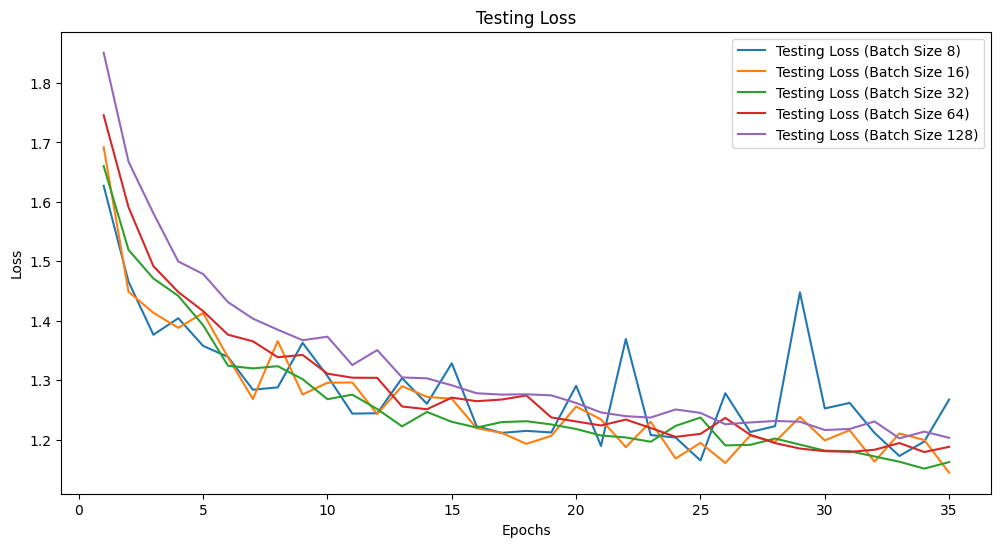

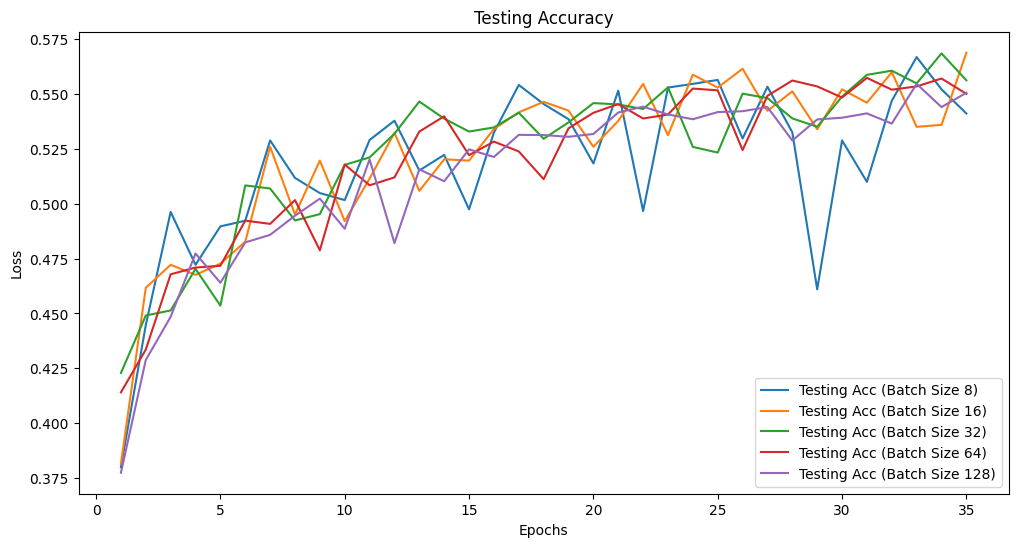

In [16]:
import matplotlib.pyplot as plt

# List of batch sizes
batch_sizes = [8, 16, 32, 64, 128]
# Plot test loss vs epoch for each batch size
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    # tr_loss = batch_tr_info[batch_size]["loss"]
    te_loss = batch_te_info[batch_size]["loss"]
    # plt.plot(range(1, len(tr_loss) + 1), tr_loss, label=f'Training Loss (Batch Size {batch_size})', color=colour)
    plt.plot(range(1, len(te_loss) + 1), te_loss, label=f'Testing Loss (Batch Size {batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Loss')
plt.legend()

plt.figure(figsize=(12, 6))
# Plot test acc vs epoch for each batch size
for batch_size in batch_sizes:
    # tr_acc = batch_tr_info[batch_size]["acc"]
    te_acc = batch_te_info[batch_size]["acc"]
    # plt.plot(range(1, len(tr_acc) + 1), tr_loss, label=f'Training Acc (Batch Size {batch_size})', color=colour)
    plt.plot(range(1, len(te_acc) + 1), te_acc, label=f'Testing Acc (Batch Size {batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy')
plt.legend()
plt.show()

Best test loss for each batch size with it's corresponding accuracy

In [18]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(
        f"Batch size {batch_size}: Epoch {best_epoch + 1} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch] * 100, 2)}% accuracy")

Batch size 8: Epoch 25 has 1.165 loss with 55.65% accuracy
Batch size 16: Epoch 35 has 1.144 loss with 56.89% accuracy
Batch size 32: Epoch 34 has 1.151 loss with 56.86% accuracy
Batch size 64: Epoch 34 has 1.179 loss with 55.71% accuracy
Batch size 128: Epoch 33 has 1.202 loss with 55.47% accuracy


# Unfreeze all layers (Batch size 16)

In [ ]:
m1 = torchvision.models.get_model("shufflenet_v2_x0_5", num_classes=10)

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

early_stopping_patience = 15
NUM_OF_EPOCHS = 100
BATCH_SIZE = 16
batch_tr_info, batch_te_info = train_and_eval(model=m1, trainset=trainset, testset=testset, batch_sizes=[BATCH_SIZE],
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="unfreeze_all_layer",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE,
                                              NUM_OF_WORKERS=NUM_OF_WORKERS)

Device: cuda:0
Epoch 1 Training...


100%|██████████| 3750/3750 [03:05<00:00, 20.18it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.33it/s]


Epoch 1: Train_accuracy: 80.44%, Train_loss: 0.526715, Test_accuracy: 87.61%, Test_loss: 0.347504
Epoch 2 Training...


100%|██████████| 3750/3750 [02:55<00:00, 21.42it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:17<00:00, 36.51it/s]


Epoch 2: Train_accuracy: 88.75%, Train_loss: 0.311425, Test_accuracy: 89.87%, Test_loss: 0.287710
Epoch 3 Training...


100%|██████████| 3750/3750 [02:48<00:00, 22.21it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:17<00:00, 36.57it/s]


Epoch 3: Train_accuracy: 90.43%, Train_loss: 0.266411, Test_accuracy: 90.70%, Test_loss: 0.258560
Epoch 4 Training...


100%|██████████| 3750/3750 [02:53<00:00, 21.62it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:17<00:00, 35.05it/s]


Epoch 4: Train_accuracy: 91.45%, Train_loss: 0.236930, Test_accuracy: 91.50%, Test_loss: 0.229207
Epoch 5 Training...


100%|██████████| 3750/3750 [02:59<00:00, 20.92it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:16<00:00, 36.85it/s]


Epoch 5: Train_accuracy: 92.11%, Train_loss: 0.215634, Test_accuracy: 91.84%, Test_loss: 0.227165
Epoch 6 Training...


100%|██████████| 3750/3750 [03:11<00:00, 19.59it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:17<00:00, 34.98it/s]


Epoch 6: Train_accuracy: 92.81%, Train_loss: 0.197104, Test_accuracy: 92.21%, Test_loss: 0.211610
Epoch 7 Training...


100%|██████████| 3750/3750 [02:55<00:00, 21.42it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:18<00:00, 34.66it/s]


Epoch 7: Train_accuracy: 93.45%, Train_loss: 0.181556, Test_accuracy: 92.39%, Test_loss: 0.215302
Epoch 8 Training...


100%|██████████| 3750/3750 [03:18<00:00, 18.88it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.96it/s]


Epoch 8: Train_accuracy: 93.82%, Train_loss: 0.168365, Test_accuracy: 91.14%, Test_loss: 0.250703
Epoch 9 Training...


100%|██████████| 3750/3750 [03:12<00:00, 19.46it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:17<00:00, 35.59it/s]


Epoch 9: Train_accuracy: 94.27%, Train_loss: 0.156215, Test_accuracy: 93.01%, Test_loss: 0.198126
Epoch 10 Training...


100%|██████████| 3750/3750 [02:38<00:00, 23.69it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:15<00:00, 39.63it/s]


Epoch 10: Train_accuracy: 94.66%, Train_loss: 0.145990, Test_accuracy: 92.63%, Test_loss: 0.206735
Epoch 11 Training...


100%|██████████| 3750/3750 [02:22<00:00, 26.26it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:14<00:00, 42.10it/s]


Epoch 11: Train_accuracy: 95.09%, Train_loss: 0.133917, Test_accuracy: 92.32%, Test_loss: 0.220928
Epoch 12 Training...


100%|██████████| 3750/3750 [02:36<00:00, 23.93it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:15<00:00, 40.09it/s]


Epoch 12: Train_accuracy: 95.35%, Train_loss: 0.125904, Test_accuracy: 92.71%, Test_loss: 0.218930
Epoch 13 Training...


100%|██████████| 3750/3750 [01:59<00:00, 31.49it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.13it/s]


Epoch 13: Train_accuracy: 95.62%, Train_loss: 0.117230, Test_accuracy: 92.40%, Test_loss: 0.214222
Epoch 14 Training...


100%|██████████| 3750/3750 [01:56<00:00, 32.10it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:12<00:00, 50.45it/s]


Epoch 14: Train_accuracy: 96.04%, Train_loss: 0.108804, Test_accuracy: 92.80%, Test_loss: 0.216280
Epoch 15 Training...


100%|██████████| 3750/3750 [01:55<00:00, 32.45it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.30it/s]


Epoch 15: Train_accuracy: 96.20%, Train_loss: 0.100933, Test_accuracy: 92.39%, Test_loss: 0.237808
Epoch 16 Training...


100%|██████████| 3750/3750 [01:54<00:00, 32.77it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.98it/s]


Epoch 16: Train_accuracy: 96.53%, Train_loss: 0.093985, Test_accuracy: 92.29%, Test_loss: 0.241647
Epoch 17 Training...


100%|██████████| 3750/3750 [01:56<00:00, 32.23it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.82it/s]


Epoch 17: Train_accuracy: 96.68%, Train_loss: 0.088109, Test_accuracy: 92.61%, Test_loss: 0.238950
Epoch 18 Training...


100%|██████████| 3750/3750 [01:54<00:00, 32.76it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:12<00:00, 50.83it/s]


Epoch 18: Train_accuracy: 97.03%, Train_loss: 0.080892, Test_accuracy: 92.59%, Test_loss: 0.235147
Epoch 19 Training...


100%|██████████| 3750/3750 [01:53<00:00, 32.93it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.75it/s]


Epoch 19: Train_accuracy: 97.27%, Train_loss: 0.075559, Test_accuracy: 92.87%, Test_loss: 0.246980
Epoch 20 Training...


100%|██████████| 3750/3750 [01:56<00:00, 32.30it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:12<00:00, 48.43it/s]


Epoch 20: Train_accuracy: 97.33%, Train_loss: 0.071370, Test_accuracy: 92.25%, Test_loss: 0.268135
Epoch 21 Training...


100%|██████████| 3750/3750 [01:55<00:00, 32.55it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:12<00:00, 49.34it/s]


Epoch 21: Train_accuracy: 97.52%, Train_loss: 0.068095, Test_accuracy: 92.90%, Test_loss: 0.254750
Epoch 22 Training...


100%|██████████| 3750/3750 [01:54<00:00, 32.79it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:12<00:00, 51.92it/s]


Epoch 22: Train_accuracy: 97.70%, Train_loss: 0.063784, Test_accuracy: 92.68%, Test_loss: 0.278461
Epoch 23 Training...


100%|██████████| 3750/3750 [01:50<00:00, 34.01it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:11<00:00, 53.53it/s]


Epoch 23: Train_accuracy: 97.77%, Train_loss: 0.060551, Test_accuracy: 92.21%, Test_loss: 0.277853
Epoch 24 Training...


100%|██████████| 3750/3750 [01:48<00:00, 34.41it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:11<00:00, 55.15it/s]

Epoch 24: Train_accuracy: 97.86%, Train_loss: 0.058387, Test_accuracy: 92.40%, Test_loss: 0.271450
Early stopping triggered. No improvement for 15 epochs.


## Plot information

Import saved information

In [11]:
file_path = 'training_information/shufflenet_v2_x0_5/unfreeze_all_layer/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/shufflenet_v2_x0_5/unfreeze_all_layer/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

Plot information

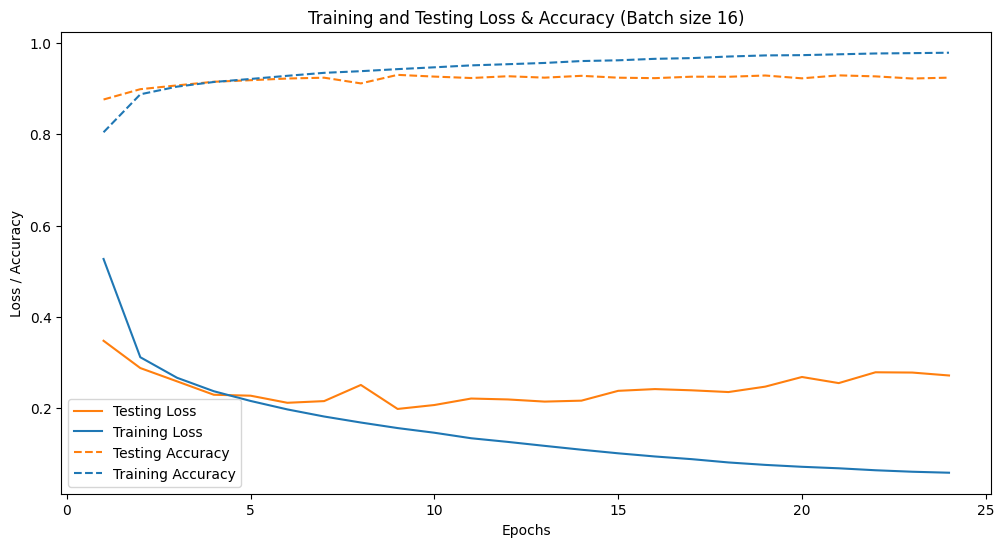

In [12]:
import matplotlib.pyplot as plt

# Specify the batch size you want to display
batch_size_to_display = 16  # previously saved it as 32 instead of 16 because of global variable 'BATCH_SIZE'

# Get the data for the specified batch size
te_loss = batch_te_info[batch_size_to_display]["loss"]
te_acc = batch_te_info[batch_size_to_display]["acc"]
tr_loss = batch_tr_info[batch_size_to_display]["loss"]
tr_acc = batch_tr_info[batch_size_to_display]["acc"]

# Create a single plot with combined training and testing information
plt.figure(figsize=(12, 6))

orange = 'tab:orange'  # Shades of orange
blue = 'tab:blue'  # An opposing color to orange

# Plot testing loss (shades of orange)
plt.plot(range(1, len(te_loss) + 1), te_loss, label=f'Testing Loss', color=orange)

# Plot training loss (shades of orange, different linestyle)
plt.plot(range(1, len(te_loss) + 1), tr_loss, label=f'Training Loss', color=blue)

# Plot testing accuracy (shades of an opposing color)
plt.plot(range(1, len(te_loss) + 1), te_acc, label=f'Testing Accuracy', linestyle='--', color=orange)

# Plot training accuracy (shades of an opposing color, different linestyle)
plt.plot(range(1, len(te_loss) + 1), tr_acc, label=f'Training Accuracy', linestyle='--', color=blue)

plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Testing Loss & Accuracy (Batch size 16)')
plt.legend()
plt.show()

Best test loss for each batch size with it's corresponding accuracy

In [13]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(f"Epoch {best_epoch} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch] * 100, 2)}% "
          f"accuracy")

Epoch 8 has 0.198 loss with 93.01% accuracy


# CutMix

In [4]:
m1 = torchvision.models.get_model("shufflenet_v2_x0_5", num_classes=10)

optimizer = torch.optim.Adam(m1.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

early_stopping_patience = 15
NUM_OF_EPOCHS = 100
BATCH_SIZE = 16

In [6]:
batch_sizes = [BATCH_SIZE]

from training_and_evaluate import train_and_eval

batch_tr_info, batch_te_info = train_and_eval(model=m1, trainset=trainset, testset=testset, batch_sizes=batch_sizes,
                                              NAME_OF_MODEL=NAME_OF_MODEL, folder_to_save_in="cutmix",
                                              NUM_OF_EPOCHS=NUM_OF_EPOCHS,
                                              early_stopping_patience=EARLY_STOPPING_PATIENCE,
                                              NUM_OF_WORKERS=NUM_OF_WORKERS, cutmix=True)

Device: cuda:0
Epoch 1 Training...


100%|██████████| 3750/3750 [01:58<00:00, 31.54it/s]


Epoch 1 Testing...


100%|██████████| 625/625 [00:14<00:00, 43.55it/s]


Epoch 1: Train_accuracy: 65.01%, Train_loss: 1.354919, Test_accuracy: 84.33%, Test_loss: 0.457233
Epoch 2 Training...


100%|██████████| 3750/3750 [03:12<00:00, 19.46it/s]


Epoch 2 Testing...


100%|██████████| 625/625 [00:22<00:00, 28.38it/s]


Epoch 2: Train_accuracy: 74.92%, Train_loss: 1.126221, Test_accuracy: 88.62%, Test_loss: 0.363900
Epoch 3 Training...


100%|██████████| 3750/3750 [04:23<00:00, 14.24it/s]


Epoch 3 Testing...


100%|██████████| 625/625 [00:21<00:00, 29.12it/s]


Epoch 3: Train_accuracy: 77.33%, Train_loss: 1.043556, Test_accuracy: 90.02%, Test_loss: 0.331276
Epoch 4 Training...


100%|██████████| 3750/3750 [04:25<00:00, 14.13it/s]


Epoch 4 Testing...


100%|██████████| 625/625 [00:21<00:00, 28.87it/s]


Epoch 4: Train_accuracy: 78.67%, Train_loss: 0.989629, Test_accuracy: 89.40%, Test_loss: 0.358989
Epoch 5 Training...


100%|██████████| 3750/3750 [04:35<00:00, 13.62it/s]


Epoch 5 Testing...


100%|██████████| 625/625 [00:21<00:00, 28.66it/s]


Epoch 5: Train_accuracy: 78.68%, Train_loss: 0.957428, Test_accuracy: 90.99%, Test_loss: 0.323425
Epoch 6 Training...


100%|██████████| 3750/3750 [04:14<00:00, 14.76it/s]


Epoch 6 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.16it/s]


Epoch 6: Train_accuracy: 79.20%, Train_loss: 0.924510, Test_accuracy: 91.01%, Test_loss: 0.311143
Epoch 7 Training...


100%|██████████| 3750/3750 [04:21<00:00, 14.35it/s]


Epoch 7 Testing...


100%|██████████| 625/625 [00:21<00:00, 28.58it/s]


Epoch 7: Train_accuracy: 79.58%, Train_loss: 0.906333, Test_accuracy: 90.62%, Test_loss: 0.320181
Epoch 8 Training...


100%|██████████| 3750/3750 [04:01<00:00, 15.54it/s]


Epoch 8 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.09it/s]


Epoch 8: Train_accuracy: 79.76%, Train_loss: 0.888365, Test_accuracy: 91.90%, Test_loss: 0.297558
Epoch 9 Training...


100%|██████████| 3750/3750 [03:59<00:00, 15.66it/s]


Epoch 9 Testing...


100%|██████████| 625/625 [00:23<00:00, 26.14it/s]


Epoch 9: Train_accuracy: 79.71%, Train_loss: 0.881802, Test_accuracy: 92.19%, Test_loss: 0.268536
Epoch 10 Training...


100%|██████████| 3750/3750 [03:58<00:00, 15.75it/s]


Epoch 10 Testing...


100%|██████████| 625/625 [00:21<00:00, 29.54it/s]


Epoch 10: Train_accuracy: 80.63%, Train_loss: 0.861706, Test_accuracy: 92.30%, Test_loss: 0.282367
Epoch 11 Training...


100%|██████████| 3750/3750 [03:56<00:00, 15.83it/s]


Epoch 11 Testing...


100%|██████████| 625/625 [00:21<00:00, 28.99it/s]


Epoch 11: Train_accuracy: 80.63%, Train_loss: 0.854077, Test_accuracy: 91.97%, Test_loss: 0.286321
Epoch 12 Training...


100%|██████████| 3750/3750 [03:55<00:00, 15.93it/s]


Epoch 12 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.65it/s]


Epoch 12: Train_accuracy: 81.21%, Train_loss: 0.846438, Test_accuracy: 92.14%, Test_loss: 0.287446
Epoch 13 Training...


100%|██████████| 3750/3750 [03:49<00:00, 16.36it/s]


Epoch 13 Testing...


100%|██████████| 625/625 [00:21<00:00, 29.16it/s]


Epoch 13: Train_accuracy: 81.21%, Train_loss: 0.834784, Test_accuracy: 93.01%, Test_loss: 0.271876
Epoch 14 Training...


100%|██████████| 3750/3750 [03:50<00:00, 16.28it/s]


Epoch 14 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.33it/s]


Epoch 14: Train_accuracy: 81.57%, Train_loss: 0.829823, Test_accuracy: 91.84%, Test_loss: 0.289744
Epoch 15 Training...


100%|██████████| 3750/3750 [03:53<00:00, 16.04it/s]


Epoch 15 Testing...


100%|██████████| 625/625 [00:20<00:00, 29.92it/s]


Epoch 15: Train_accuracy: 81.62%, Train_loss: 0.827728, Test_accuracy: 93.33%, Test_loss: 0.249086
Epoch 16 Training...


100%|██████████| 3750/3750 [03:55<00:00, 15.92it/s]


Epoch 16 Testing...


100%|██████████| 625/625 [00:21<00:00, 28.82it/s]


Epoch 16: Train_accuracy: 81.86%, Train_loss: 0.825216, Test_accuracy: 92.51%, Test_loss: 0.276333
Epoch 17 Training...


100%|██████████| 3750/3750 [03:47<00:00, 16.50it/s]


Epoch 17 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.99it/s]


Epoch 17: Train_accuracy: 81.94%, Train_loss: 0.813542, Test_accuracy: 92.70%, Test_loss: 0.253914
Epoch 18 Training...


100%|██████████| 3750/3750 [03:26<00:00, 18.13it/s]


Epoch 18 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.50it/s]


Epoch 18: Train_accuracy: 82.20%, Train_loss: 0.810215, Test_accuracy: 93.05%, Test_loss: 0.255998
Epoch 19 Training...


100%|██████████| 3750/3750 [03:33<00:00, 17.53it/s]


Epoch 19 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.08it/s]


Epoch 19: Train_accuracy: 82.18%, Train_loss: 0.806540, Test_accuracy: 92.95%, Test_loss: 0.266760
Epoch 20 Training...


100%|██████████| 3750/3750 [03:43<00:00, 16.81it/s]


Epoch 20 Testing...


100%|██████████| 625/625 [00:20<00:00, 31.12it/s]


Epoch 20: Train_accuracy: 82.70%, Train_loss: 0.795956, Test_accuracy: 93.60%, Test_loss: 0.257588
Epoch 21 Training...


100%|██████████| 3750/3750 [03:52<00:00, 16.15it/s]


Epoch 21 Testing...


100%|██████████| 625/625 [00:21<00:00, 29.06it/s]


Epoch 21: Train_accuracy: 82.93%, Train_loss: 0.790620, Test_accuracy: 93.12%, Test_loss: 0.272026
Epoch 22 Training...


100%|██████████| 3750/3750 [03:54<00:00, 16.00it/s]


Epoch 22 Testing...


100%|██████████| 625/625 [00:20<00:00, 29.87it/s]


Epoch 22: Train_accuracy: 82.78%, Train_loss: 0.794522, Test_accuracy: 93.42%, Test_loss: 0.254449
Epoch 23 Training...


100%|██████████| 3750/3750 [03:40<00:00, 16.99it/s]


Epoch 23 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.06it/s]


Epoch 23: Train_accuracy: 82.91%, Train_loss: 0.789217, Test_accuracy: 93.42%, Test_loss: 0.265885
Epoch 24 Training...


100%|██████████| 3750/3750 [03:22<00:00, 18.53it/s]


Epoch 24 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.34it/s]


Epoch 24: Train_accuracy: 83.42%, Train_loss: 0.781703, Test_accuracy: 93.43%, Test_loss: 0.247100
Epoch 25 Training...


100%|██████████| 3750/3750 [03:24<00:00, 18.37it/s]


Epoch 25 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.28it/s]


Epoch 25: Train_accuracy: 83.09%, Train_loss: 0.785755, Test_accuracy: 93.62%, Test_loss: 0.258746
Epoch 26 Training...


100%|██████████| 3750/3750 [03:33<00:00, 17.58it/s]


Epoch 26 Testing...


100%|██████████| 625/625 [00:19<00:00, 31.67it/s]


Epoch 26: Train_accuracy: 83.64%, Train_loss: 0.777208, Test_accuracy: 93.57%, Test_loss: 0.251393
Epoch 27 Training...


100%|██████████| 3750/3750 [03:31<00:00, 17.76it/s]


Epoch 27 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.24it/s]


Epoch 27: Train_accuracy: 82.95%, Train_loss: 0.780548, Test_accuracy: 93.21%, Test_loss: 0.265875
Epoch 28 Training...


100%|██████████| 3750/3750 [03:34<00:00, 17.51it/s]


Epoch 28 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.62it/s]


Epoch 28: Train_accuracy: 83.82%, Train_loss: 0.771523, Test_accuracy: 93.56%, Test_loss: 0.238509
Epoch 29 Training...


100%|██████████| 3750/3750 [03:55<00:00, 15.92it/s]


Epoch 29 Testing...


100%|██████████| 625/625 [00:19<00:00, 32.10it/s]


Epoch 29: Train_accuracy: 83.43%, Train_loss: 0.770915, Test_accuracy: 93.78%, Test_loss: 0.247515
Epoch 30 Training...


100%|██████████| 3750/3750 [04:11<00:00, 14.92it/s]


Epoch 30 Testing...


100%|██████████| 625/625 [00:22<00:00, 28.38it/s]


Epoch 30: Train_accuracy: 83.59%, Train_loss: 0.772520, Test_accuracy: 93.42%, Test_loss: 0.241013
Epoch 31 Training...


100%|██████████| 3750/3750 [03:45<00:00, 16.60it/s]


Epoch 31 Testing...


100%|██████████| 625/625 [00:18<00:00, 34.09it/s]


Epoch 31: Train_accuracy: 83.97%, Train_loss: 0.763564, Test_accuracy: 93.70%, Test_loss: 0.251981
Epoch 32 Training...


100%|██████████| 3750/3750 [05:07<00:00, 12.20it/s]


Epoch 32 Testing...


100%|██████████| 625/625 [00:23<00:00, 26.59it/s]


Epoch 32: Train_accuracy: 84.10%, Train_loss: 0.764670, Test_accuracy: 93.86%, Test_loss: 0.235229
Epoch 33 Training...


100%|██████████| 3750/3750 [04:48<00:00, 13.00it/s]


Epoch 33 Testing...


100%|██████████| 625/625 [00:24<00:00, 25.62it/s]


Epoch 33: Train_accuracy: 84.43%, Train_loss: 0.758959, Test_accuracy: 93.58%, Test_loss: 0.270622
Epoch 34 Training...


100%|██████████| 3750/3750 [04:35<00:00, 13.60it/s]


Epoch 34 Testing...


100%|██████████| 625/625 [00:25<00:00, 24.58it/s]


Epoch 34: Train_accuracy: 84.19%, Train_loss: 0.754368, Test_accuracy: 93.82%, Test_loss: 0.222827
Epoch 35 Training...


100%|██████████| 3750/3750 [04:32<00:00, 13.77it/s]


Epoch 35 Testing...


100%|██████████| 625/625 [00:24<00:00, 25.98it/s]


Epoch 35: Train_accuracy: 84.25%, Train_loss: 0.753962, Test_accuracy: 93.17%, Test_loss: 0.262756
Epoch 36 Training...


100%|██████████| 3750/3750 [04:32<00:00, 13.78it/s]


Epoch 36 Testing...


100%|██████████| 625/625 [00:23<00:00, 26.31it/s]


Epoch 36: Train_accuracy: 84.36%, Train_loss: 0.753922, Test_accuracy: 94.24%, Test_loss: 0.231296
Epoch 37 Training...


100%|██████████| 3750/3750 [04:10<00:00, 14.99it/s]


Epoch 37 Testing...


100%|██████████| 625/625 [00:17<00:00, 36.12it/s]


Epoch 37: Train_accuracy: 84.07%, Train_loss: 0.755495, Test_accuracy: 93.61%, Test_loss: 0.275017
Epoch 38 Training...


100%|██████████| 3750/3750 [03:14<00:00, 19.30it/s]


Epoch 38 Testing...


100%|██████████| 625/625 [00:17<00:00, 35.02it/s]


Epoch 38: Train_accuracy: 84.88%, Train_loss: 0.752095, Test_accuracy: 93.72%, Test_loss: 0.245131
Epoch 39 Training...


100%|██████████| 3750/3750 [03:14<00:00, 19.26it/s]


Epoch 39 Testing...


100%|██████████| 625/625 [00:17<00:00, 35.69it/s]


Epoch 39: Train_accuracy: 84.71%, Train_loss: 0.750789, Test_accuracy: 93.48%, Test_loss: 0.244246
Epoch 40 Training...


100%|██████████| 3750/3750 [03:19<00:00, 18.79it/s]


Epoch 40 Testing...


100%|██████████| 625/625 [00:16<00:00, 38.31it/s]


Epoch 40: Train_accuracy: 84.59%, Train_loss: 0.746712, Test_accuracy: 93.94%, Test_loss: 0.229070
Epoch 41 Training...


100%|██████████| 3750/3750 [03:21<00:00, 18.64it/s]


Epoch 41 Testing...


100%|██████████| 625/625 [00:18<00:00, 34.49it/s]


Epoch 41: Train_accuracy: 84.88%, Train_loss: 0.748668, Test_accuracy: 93.96%, Test_loss: 0.257920
Epoch 42 Training...


100%|██████████| 3750/3750 [03:26<00:00, 18.14it/s]


Epoch 42 Testing...


100%|██████████| 625/625 [00:17<00:00, 35.06it/s]


Epoch 42: Train_accuracy: 84.73%, Train_loss: 0.742021, Test_accuracy: 94.19%, Test_loss: 0.228800
Epoch 43 Training...


100%|██████████| 3750/3750 [03:27<00:00, 18.03it/s]


Epoch 43 Testing...


100%|██████████| 625/625 [00:17<00:00, 35.54it/s]


Epoch 43: Train_accuracy: 84.99%, Train_loss: 0.743047, Test_accuracy: 93.63%, Test_loss: 0.229004
Epoch 44 Training...


100%|██████████| 3750/3750 [03:24<00:00, 18.30it/s]


Epoch 44 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.63it/s]


Epoch 44: Train_accuracy: 85.00%, Train_loss: 0.740677, Test_accuracy: 93.64%, Test_loss: 0.227075
Epoch 45 Training...


100%|██████████| 3750/3750 [03:26<00:00, 18.16it/s]


Epoch 45 Testing...


100%|██████████| 625/625 [00:18<00:00, 33.43it/s]


Epoch 45: Train_accuracy: 84.86%, Train_loss: 0.742827, Test_accuracy: 93.68%, Test_loss: 0.270781
Epoch 46 Training...


100%|██████████| 3750/3750 [03:24<00:00, 18.31it/s]


Epoch 46 Testing...


100%|██████████| 625/625 [00:17<00:00, 34.78it/s]


Epoch 46: Train_accuracy: 84.72%, Train_loss: 0.736439, Test_accuracy: 93.32%, Test_loss: 0.249585
Epoch 47 Training...


100%|██████████| 3750/3750 [03:24<00:00, 18.36it/s]


Epoch 47 Testing...


100%|██████████| 625/625 [00:17<00:00, 36.12it/s]


Epoch 47: Train_accuracy: 85.20%, Train_loss: 0.734004, Test_accuracy: 93.13%, Test_loss: 0.320307
Epoch 48 Training...


100%|██████████| 3750/3750 [03:20<00:00, 18.72it/s]


Epoch 48 Testing...


100%|██████████| 625/625 [00:16<00:00, 36.94it/s]


Epoch 48: Train_accuracy: 84.99%, Train_loss: 0.737984, Test_accuracy: 93.73%, Test_loss: 0.274438
Epoch 49 Training...


100%|██████████| 3750/3750 [03:28<00:00, 17.96it/s]


Epoch 49 Testing...


100%|██████████| 625/625 [00:20<00:00, 30.89it/s]

Epoch 49: Train_accuracy: 85.32%, Train_loss: 0.732279, Test_accuracy: 93.60%, Test_loss: 0.245073
Early stopping triggered. No improvement for 15 epochs.


## Plot information

Import saved information

In [19]:
file_path = 'training_information/shufflenet_v2_x0_5/cutmix/batch_te_info.pkl'
with open(file_path, 'rb') as file:
    batch_te_info = pickle.load(file)
file_path = 'training_information/shufflenet_v2_x0_5/cutmix/batch_tr_info.pkl'
with open(file_path, 'rb') as file:
    batch_tr_info = pickle.load(file)

Plot information

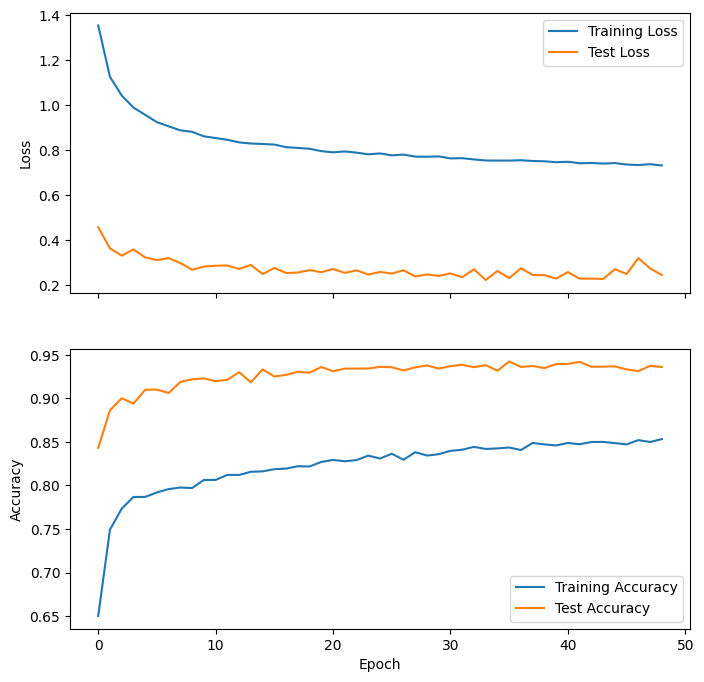

In [20]:
import matplotlib.pyplot as plt

# Create a figure with larger subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))  # Adjust the figsize as needed

# Plot the training and test loss on the first subplot
ax1.plot(batch_tr_info[BATCH_SIZE]["loss"], label="Training Loss")
ax1.plot(batch_te_info[BATCH_SIZE]["loss"], label="Test Loss")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot the training and test accuracy on the second subplot
ax2.plot(batch_tr_info[BATCH_SIZE]["acc"], label="Training Accuracy")
ax2.plot(batch_te_info[BATCH_SIZE]["acc"], label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Show the plot
plt.show()

Best test loss for each batch size with it's corresponding accuracy

In [21]:
for batch_size, info in batch_te_info.items():
    best_test_loss = 100
    best_epoch = 0
    for epoch, loss in enumerate(info["loss"]):
        if best_test_loss > loss:
            best_test_loss = loss
            best_epoch = epoch
    print(
        f"Batch size {batch_size}: Epoch {best_epoch + 1} has {round(best_test_loss, 3)} loss with {round(info['acc'][best_epoch] * 100, 2)}% accuracy")

Batch size 16: Epoch 34 has 0.223 loss with 93.82% accuracy
